# Analysis of the SSVEP data

Let's load a couple libraries we'll use repeatedly, and set the default plot size.

In [1]:
library(dplyr, warn.conflicts=FALSE)
library(stringr)
library(ggplot2)

options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

# Setup / preprocessing

The dataframe we're about to load has already undergone fourier transform & projection to FSAverage cortical space, so we're dealing with vertex numbers and frequency bin amplitudes, across subject and pre/post intervention measurement times.  This assumes it's in the same folder as the notebook; adjust path as needed:

**NOTE:** at the end of this section, we save out the munged data, so you can skip these cells on later runs.

## Load the cohort groupings

In [2]:
file.path("..", "..", "params") -> param_dir

# load intervention groups
file.path(param_dir, "intervention_cohorts.yaml") -> intervention_file
yaml::read_yaml(intervention_file) -> intervention

# load pre-test cohorts
file.path(param_dir, "letter_knowledge_cohorts.yaml") -> pretest_file
yaml::read_yaml(pretest_file) -> pretest

## Load and clean the brain data

In [3]:
proc.time() -> start
readr::read_csv("all_subjects-fsaverage-freq_domain-stc.csv") -> all_data
print(proc.time() - start)

Parsed with column specification:
cols(
  subject = col_character(),
  freq = col_double(),
  source = col_character(),
  value = col_double(),
  timepoint = col_character()
)



   user  system elapsed 
174.616   2.228 176.854 


Now to merge in the cohort groupings and do some light cleaning:

In [4]:
proc.time() -> start
all_data %>%
    tidyr::separate(source, c("hemi", "vertex"), sep="_") %>%
    rename(amplitude=value) %>%
    mutate(hemi=str_to_lower(hemi),
           vertex=as.integer(vertex),
           subj_num=str_sub(subject, -4),
           intervention=if_else(subj_num %in% intervention$LetterIntervention, "letter", "language"),
           pretest=if_else(subj_num %in% pretest$LowerKnowledge, "lower", "upper")) %>%
    # set column order
    select(subject, pretest, intervention, timepoint, freq, hemi, vertex, amplitude, -subj_num) ->
    all_data
print(proc.time() - start)

print(all_data)

   user  system elapsed 
206.898   8.884 215.795 
# A tibble: 247,774,464 x 8
   subject   pretest intervention timepoint  freq hemi  vertex amplitude
   <chr>     <chr>   <chr>        <chr>     <dbl> <chr>  <int>     <dbl>
 1 prek_1103 lower   language     pre           0 lh         0      21.9
 2 prek_1103 lower   language     pre           0 lh         1      57.1
 3 prek_1103 lower   language     pre           0 lh         2      50.4
 4 prek_1103 lower   language     pre           0 lh         3     125. 
 5 prek_1103 lower   language     pre           0 lh         4      69.9
 6 prek_1103 lower   language     pre           0 lh         5      13.2
 7 prek_1103 lower   language     pre           0 lh         6      29.3
 8 prek_1103 lower   language     pre           0 lh         7      46.5
 9 prek_1103 lower   language     pre           0 lh         8      78.1
10 prek_1103 lower   language     pre           0 lh         9      15.5
# … with 247,774,454 more rows


## Compute noise and SNR

Next we'll define a function that will compute noise (the mean of the two frequency bins below and two frequency bins above the current bin), and apply it within a `group_by` operation.

In [5]:
# function to compute noise (mean of 2 bins above and below; handles edges gracefully)
compute_noise <- function(x) {
    rowMeans(cbind(lag(x, 2), lag(x, 1), lead(x, 1), lead(x, 2)), na.rm=TRUE)
}

all_data %>%
    group_by(subject, timepoint, hemi, vertex) %>%
    mutate(noise=compute_noise(amplitude),
           snr=amplitude/noise) %>%
    ungroup() ->
    all_data

### Plot the frequency spectrum

Let's take a look at the average power spectrum across all vertices and subjects. The target frequencies are 2 Hz and 6 Hz, but we'll also highlight harmonics at 4, 12, and 18 Hz.

In [6]:
all_data %>%
    group_by(timepoint, freq) %>%
    summarise_at(c("amplitude", "snr"), mean) %>%
    mutate(target_freq=freq %in% c(2, 4, 6, 12, 18)) ->
    spectrum

print(spectrum)

# A tibble: 252 x 5
# Groups:   timepoint [2]
   timepoint  freq amplitude   snr target_freq
   <chr>     <dbl>     <dbl> <dbl> <lgl>      
 1 post        0       223.  0.748 FALSE      
 2 post        0.2     112.  1.57  FALSE      
 3 post        0.4     108.  1.38  FALSE      
 4 post        0.6      75.1 0.986 FALSE      
 5 post        0.8      62.3 0.990 FALSE      
 6 post        1        65.7 1.16  FALSE      
 7 post        1.2      54.9 1.02  FALSE      
 8 post        1.4      48.9 1.05  FALSE      
 9 post        1.6      44.8 1.01  FALSE      
10 post        1.8      39.1 0.994 FALSE      
# … with 242 more rows


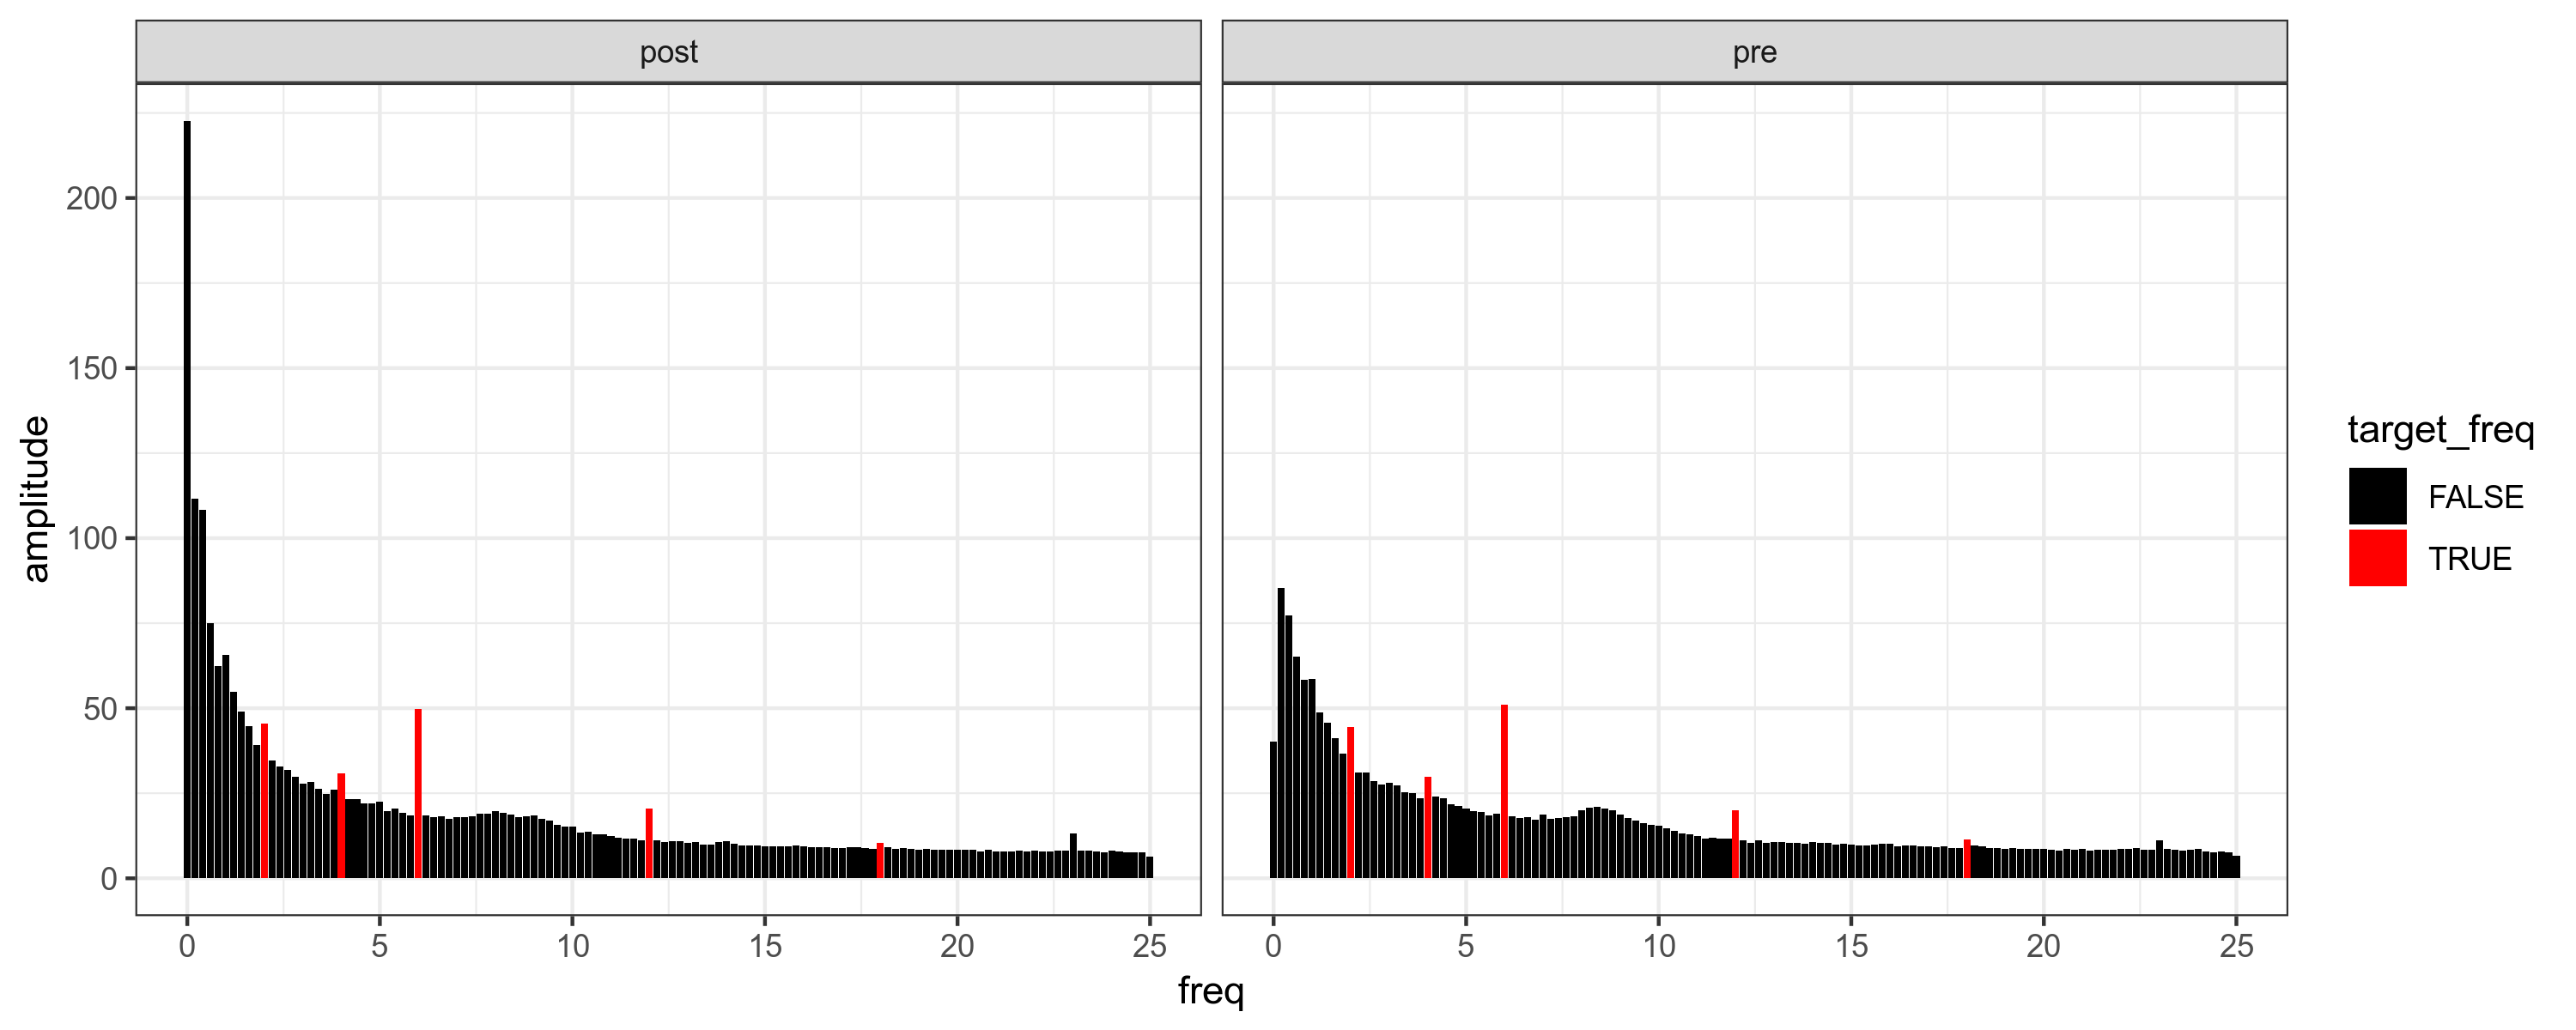

In [7]:
spectrum %>%
    ggplot(aes(x=freq, y=amplitude, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

OK, typical $\frac{1}{f}$ shape, with our target frequencies (and their harmonics) poking out. Let's flatten out the spectrum by looking at SNR instead of raw amplitude in each bin:

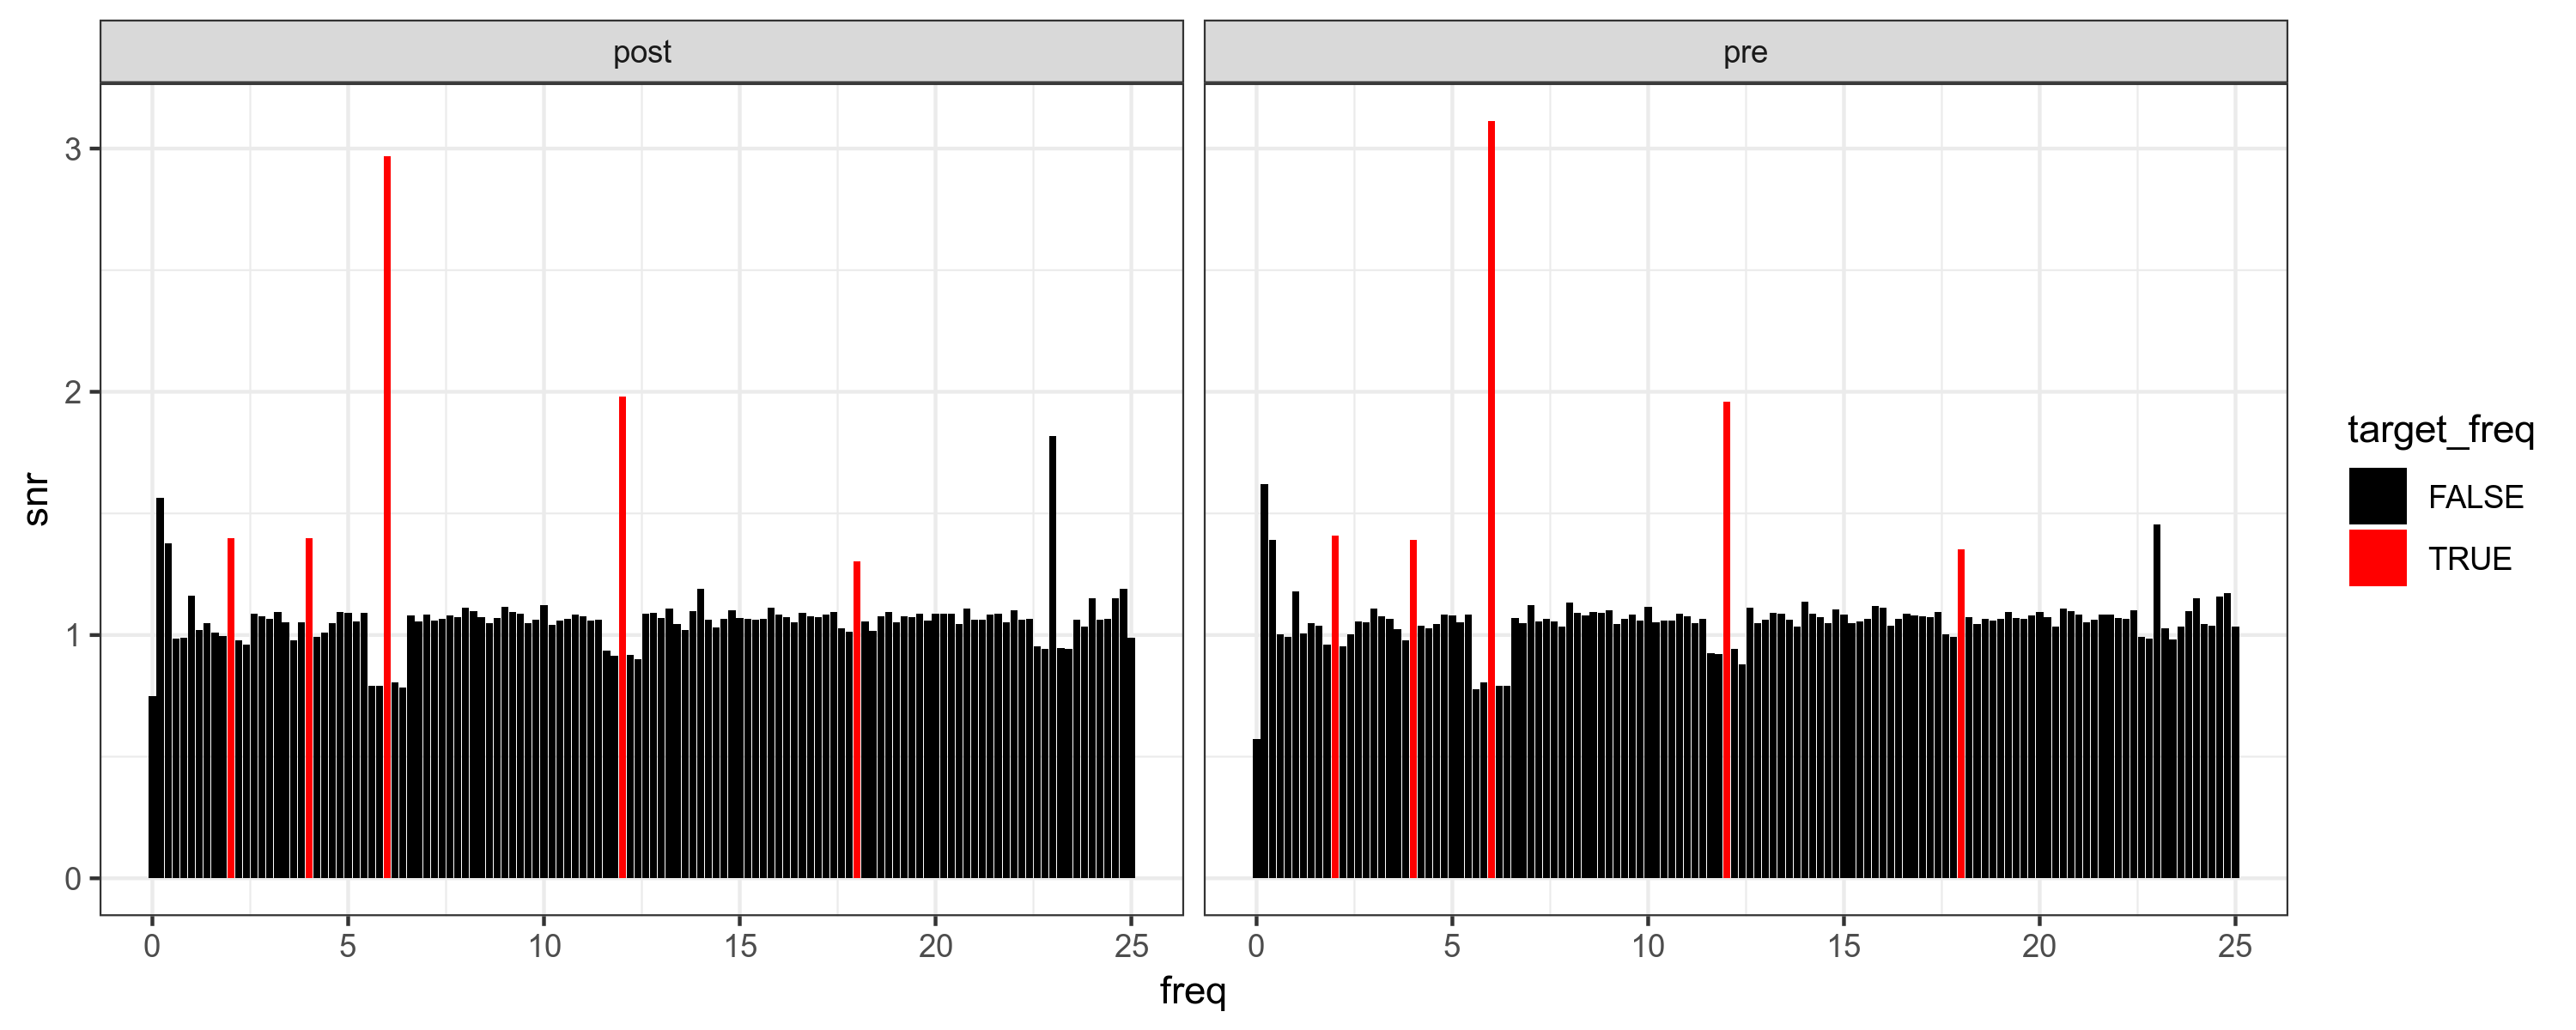

In [8]:
spectrum %>%
    ggplot(aes(x=freq, y=snr, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

That spike at 23 Hz (which is bigger in the post-intervention data) is a bit of a mystery.

## Load SNR-based ROI labels

These are lists of vertices stored in YAML files, and are based on SNR thresholds of 2.0 (generous) or 2.2 (stringent) after pooling across all subjects and both pre- and post-camp measurements.

In [9]:
list() -> label_verts

for(snr in c("2.0", "2.2")) {
    file.path("..", "ROIs", str_c("2_Hz-SNR_", snr, ".yaml")) -> verts_file
    yaml::read_yaml(verts_file) -> these_verts
    str_c("snr", snr, names(these_verts), sep="_") -> names(these_verts)
    c(label_verts, these_verts) -> label_verts
}

For now we'll use the more stringent ROI:

In [10]:
"snr_2.2_lh" -> lh_label
"snr_2.2_rh" -> rh_label

all_data %>%
    mutate(label=case_when(vertex %in% label_verts[[lh_label]] ~ "lh",
                           vertex %in% label_verts[[rh_label]] ~ "rh",
                           TRUE ~ NA_character_)) %>%
    filter(freq == 2, !is.na(label)) %>%
    group_by(subject, timepoint, intervention, pretest, hemi) %>%
    summarise_at(c("amplitude", "noise", "snr"), mean) %>%
    ungroup() ->
    roi_data

print(roi_data)

# A tibble: 192 x 8
   subject   timepoint intervention pretest hemi  amplitude noise   snr
   <chr>     <chr>     <chr>        <chr>   <chr>     <dbl> <dbl> <dbl>
 1 prek_1103 post      language     lower   lh         38.6  27.0  1.60
 2 prek_1103 post      language     lower   rh         79.8  40.2  2.13
 3 prek_1103 pre       language     lower   lh         51.0  28.8  1.86
 4 prek_1103 pre       language     lower   rh         70.2  22.9  3.27
 5 prek_1110 post      language     upper   lh         43.3  22.9  2.03
 6 prek_1110 post      language     upper   rh         32.7  23.6  1.58
 7 prek_1110 pre       language     upper   lh         43.0  20.3  2.56
 8 prek_1110 pre       language     upper   rh         40.5  26.4  1.69
 9 prek_1112 post      letter       lower   lh         68.6  58.1  1.20
10 prek_1112 post      letter       lower   rh         73.5  55.8  1.43
# … with 182 more rows


Now we save the preprocessing work, so we don't have to do it every time:

In [11]:
save(roi_data, file="processed_data_with_SNR_based_labels.RData")
rm(all_data)  # free up memory

## Start here if skipping the preprocessing section

In [12]:
# load("processed_data_with_tvals.RData")
# OR
# load("processed_data_with_SNR_based_labels.RData")
# (either one will load an object called "roi_data")

## Testing the main hypotheses

Now that we have our ROI data, let's test our hypotheses. We'll do it separately for each hemisphere.

### t-test of pre-intervention letter awareness

First we'll compare the two pretest groups (median split on the pre-intervention letter awareness test):

In [13]:
roi_data %>%
    filter(timepoint == "pre") %>%
    group_by(hemi) %>%
    do(broom::tidy(t.test(amplitude ~ pretest, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    pretest_tvals

pretest_tvals

hemi,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
lh,-2.872442,55.17278,58.04522,-0.4662897,0.6433118,43.93726,-15.288032,9.543147,Welch Two Sample t-test,two.sided
rh,7.877461,64.02100,56.14354,1.0282977,0.3101481,38.98320,-7.617943,23.372866,Welch Two Sample t-test,two.sided


### t-test of intervention effect

For the intervention effect, what we care about is *change* in activation pre-versus-post intervention, so we'll need to do a `post - pre` subtraction first:

In [14]:
roi_data %>%
    tidyr::pivot_wider(names_from=timepoint, values_from=amplitude, id_cols=c(subject, intervention, hemi)) %>%
    mutate(post_minus_pre=post - pre) %>%
    group_by(hemi) %>%
    do(broom::tidy(t.test(post_minus_pre ~ intervention, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    intervention_tvals

intervention_tvals

hemi,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
lh,-11.42828,-7.295404,4.132879,-1.601740,0.1167324,41.86768,-25.82848,2.971915,Welch Two Sample t-test,two.sided
rh,-10.47940,-6.774010,3.705390,-1.255434,0.2157221,45.56136,-27.28588,6.327079,Welch Two Sample t-test,two.sided


# Mixed model of intervention effect

Next let's see what the intervention effect looks like as a mixed model.

In [15]:
head(roi_data)

subject,timepoint,intervention,pretest,hemi,amplitude,noise,snr
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
prek_1103,post,language,lower,lh,38.57191,26.98713,1.597878
prek_1103,post,language,lower,rh,79.80829,40.24879,2.125225
prek_1103,pre,language,lower,lh,51.03467,28.75257,1.857166
prek_1103,pre,language,lower,rh,70.20071,22.91224,3.265584
prek_1110,post,language,upper,lh,43.30528,22.86449,2.028432
prek_1110,post,language,upper,rh,32.73995,23.60898,1.581344


In [16]:
# create factor variables and set contrasts
dev_contrast <- function(x, ...) {
    x <- factor(x, ...)
    contrasts(x) <- contr.sum
    contrasts(x) <- contrasts(x) / 2
    colnames(contrasts(x)) <- paste0("_", levels(x)[-length(levels(x))])
    x
}

roi_data %>%
    mutate(tpt=dev_contrast(timepoint, levels=c("pre", "post")),
           grp=dev_contrast(intervention, levels=c("language", "letter"))) %>%
    afex::mixed(snr ~ tpt * grp + (1|subject), data=., method="PB", REML=FALSE, check_contrasts=FALSE) ->
    model

summary(model)

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[...]


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: snr ~ tpt * grp + (1 | subject)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   417.9    437.5   -203.0    405.9      186 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9252 -0.6336 -0.1971  0.3733  3.5863 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.2702   0.5199  
 Residual             0.3390   0.5822  
Number of obs: 192, groups:  subject, 48

Fixed effects:
                      Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)            2.10312    0.08600  48.00000  24.455   <2e-16 ***
tpt_pre                0.10720    0.08403 144.00000   1.276   0.2041    
grp_language          -0.17164    0.17200  48.00000  -0.998   0.3233    
tpt_pre:grp_language   0.34540    0.16807 144.00000   2.055   0.0417 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed 

# More detailed regressions

Here we explore the relationship between our ROI data and the various pre-test variables / dimensions.

### Load and clean behavioral metadata

First let's load the behavioral scores. We'll clean up a few columns and drop ones we don't need.

In [17]:
# load metadata
readr::read_csv(file.path("..", "behavioral", "preK_InterventionData.csv")) %>%
    # rename/transform variables
    rename(timepoint=visit) %>%
    mutate(subject=str_c("prek_", subID),
           intervention=str_to_lower(group)) %>%
    # reorder columns and drop unwanted columns
    select(subject, timepoint, intervention, everything(), -event, -subID, -group) ->
    metadata

print(metadata)

Parsed with column specification:
cols(
  subID = col_double(),
  event = col_character(),
  group = col_character(),
  AlphabetKnowledge = col_double(),
  Decoding = col_double(),
  PhonemeMatching = col_double(),
  PhonemeSegmenting = col_double(),
  EVTRaw = col_double(),
  Retell = col_double(),
  Grammar = col_double(),
  visit = col_character()
)



# A tibble: 96 x 10
   subject timepoint intervention AlphabetKnowled… Decoding PhonemeMatching
   <chr>   <chr>     <chr>                   <dbl>    <dbl>           <dbl>
 1 prek_1… pre       language                   49        0               7
 2 prek_1… post      language                   59        0               8
 3 prek_1… pre       language                   90        4              12
 4 prek_1… post      language                   93        0              12
 5 prek_1… pre       letter                     23        0              12
 6 prek_1… post      letter                     36        0              14
 7 prek_1… pre       language                   31        0               7
 8 prek_1… post      language                   34        0               8
 9 prek_1… pre       language                   82        0              15
10 prek_1… post      language                   89        5               8
# … with 86 more rows, and 4 more variables: PhonemeSegmenting <dbl>

### Merge brain data and metadata

Now we'll join our brain data and metadata.

In [18]:
roi_data %>%
    left_join(metadata, by=c("subject", "timepoint", "intervention")) ->
    roi_data

### Sample scatterplot

Let's take a look now at the relationship between the pre-test variables and the average 2 Hz response.

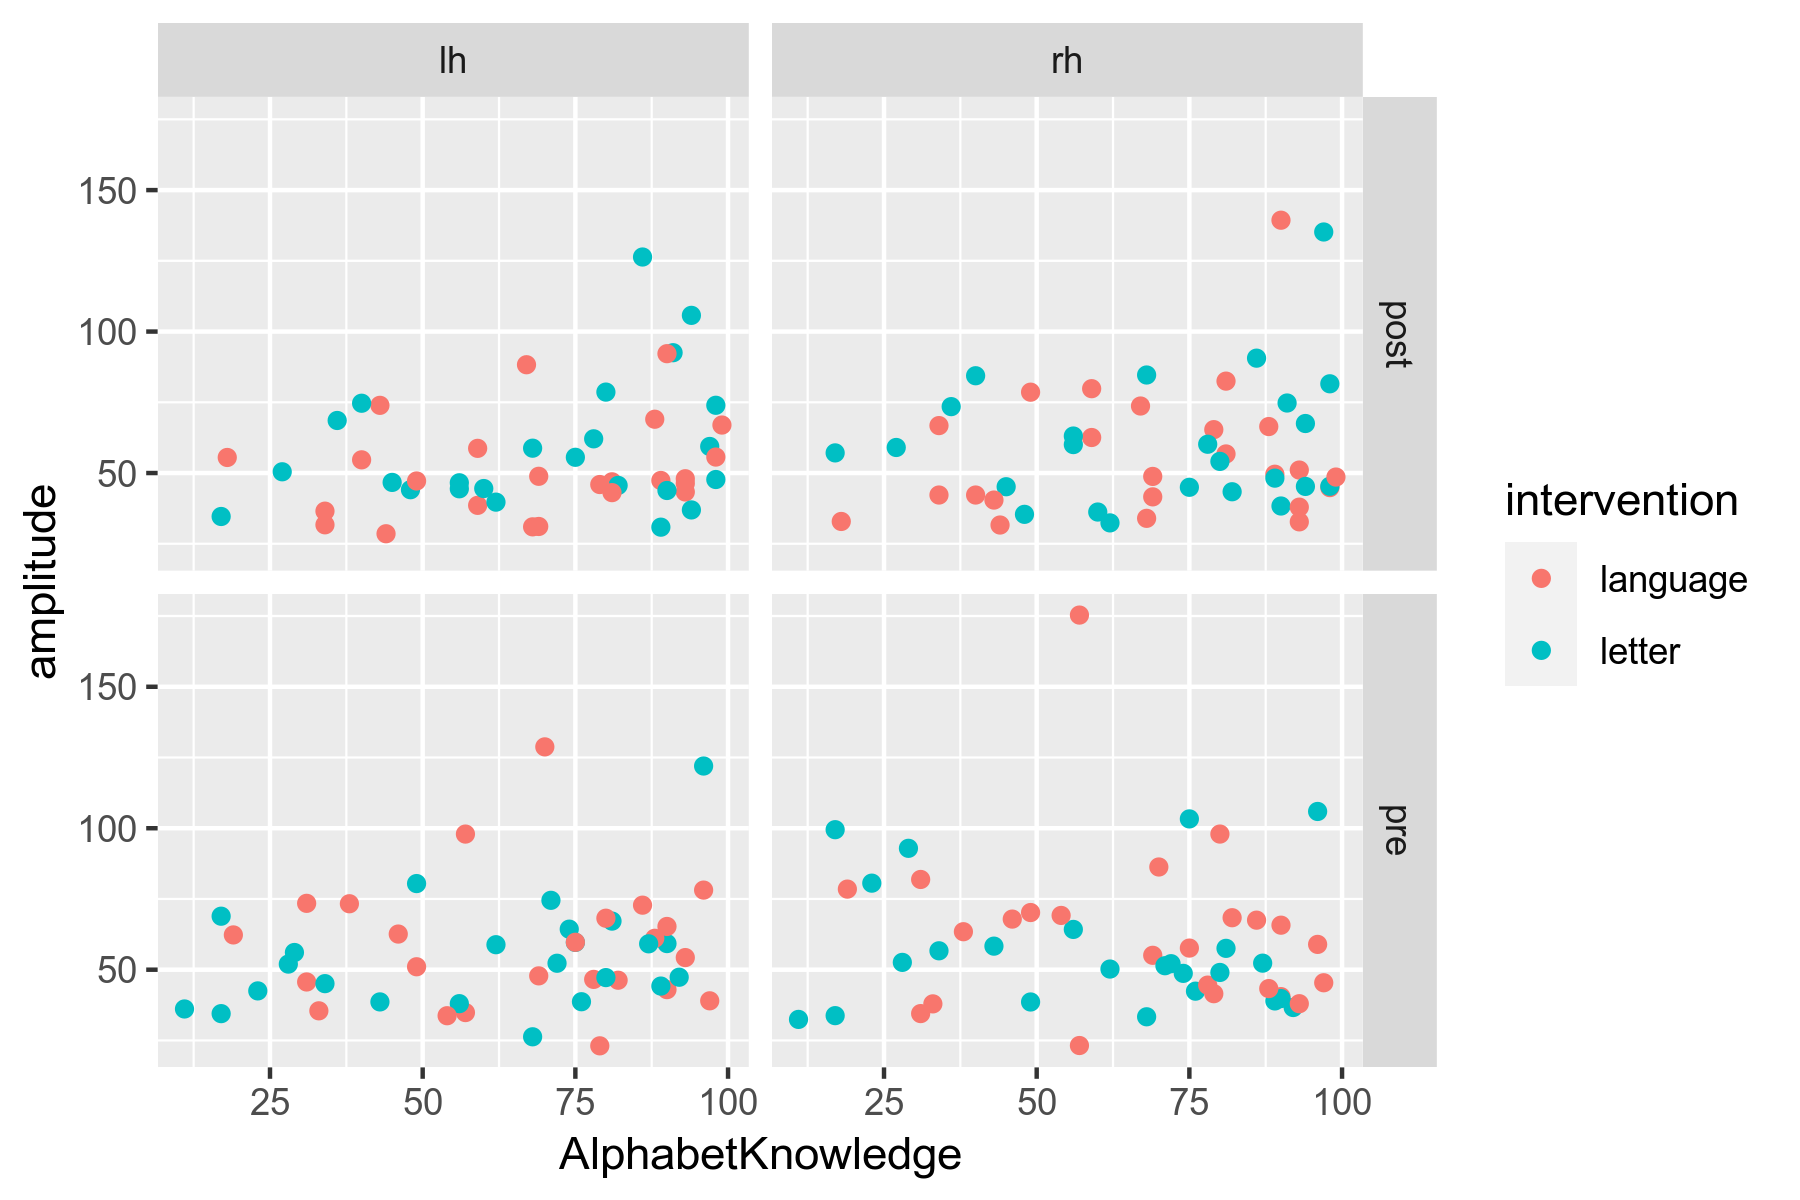

In [19]:
options(repr.plot.width=6)

roi_data %>%
    ggplot(aes(x=AlphabetKnowledge, y=amplitude, colour=intervention)) + 
    facet_grid(timepoint ~ hemi) + 
    geom_point()